# Explainable AI Applied to Boosted Trees
_**Mobile Customer Churn Example**_

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Compile](#Compile)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. In doing so, this notebook illustrates several methods of assessing the impact of input features on the target variable. These including demonstrations of and theoretical justifications of feature importance, partial dependence, and skater

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
bucket = 'mw-simple-data'
prefix = 'sagemaker/DEMO-xgboost-churn'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [4]:
!pip install xgboost
!pip install shap
!pip install lime

    100% |████████████████████████████████| 109.8MB 428kB/s eta 0:00:01
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 276kB 13.0MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 27.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for shap ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 276kB 14.1MB/s ta 0:00:01
    100% |████████████████████████████████| 2.0MB 17.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for lime ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/22/f2/ec/e5ebd07348b2b1ac722e91c2f549fcc220f7d5f25497a61232
Suc

In [39]:
import pandas as pd #for manipulating data
import numpy as np #for manipulating data
import sklearn #for building models
import xgboost as xgb #for building models
import sklearn.ensemble #for building models
from sklearn.model_selection import train_test_split #for creating a hold-out sample
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
import shap #SHAP package
import time #some of the routines take a while so we monitor the time
import os #needed to use Environment Variables in Domino
import matplotlib.pyplot as plt #for custom graphs at the end
import seaborn as sns #for custom graphs at the end

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [ ]:
#!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
#!unzip -o DKD2e_data_sets.zip

In [6]:
churn = pd.read_csv('./Data sets/churn.txt')
pd.set_option('display.max_columns', 500)
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
327-3954,0.0003
327-4795,0.0003
327-5525,0.0003
327-5817,0.0003


col_0,% observations
Int'l Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


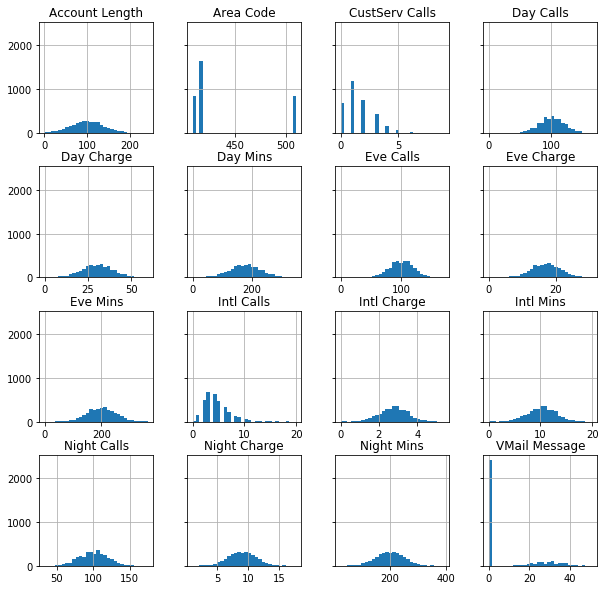

In [7]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:
- `State` appears to be quite evenly distributed
- `Phone` takes on too many unique values to be of any practical use.  It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

In [8]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

Next let's look at the relationship between each of the features and our target variable.

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Area Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


Account Length


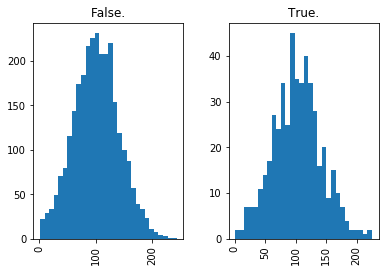

VMail Message


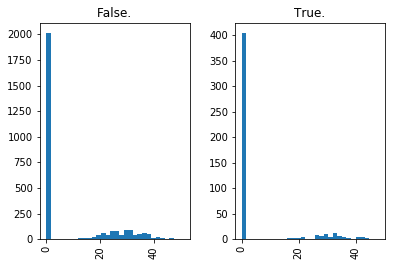

Day Mins


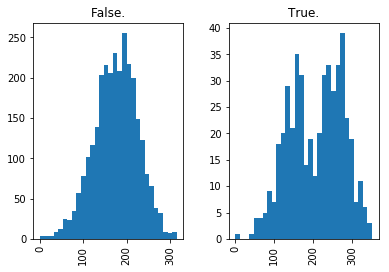

Day Calls


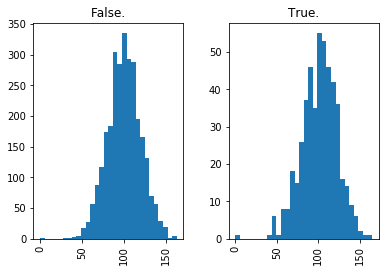

Day Charge


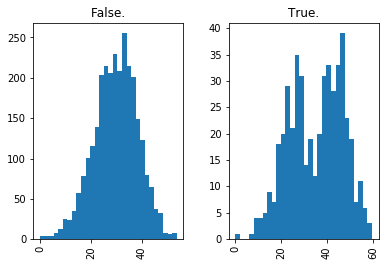

Eve Mins


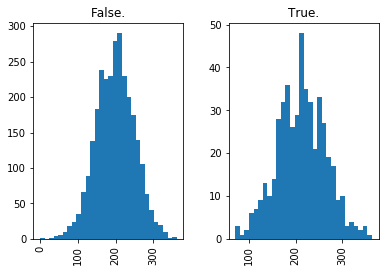

Eve Calls


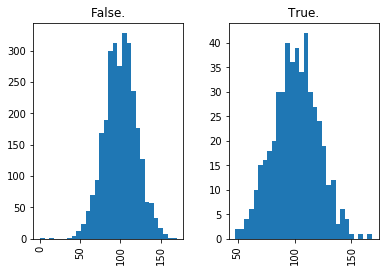

Eve Charge


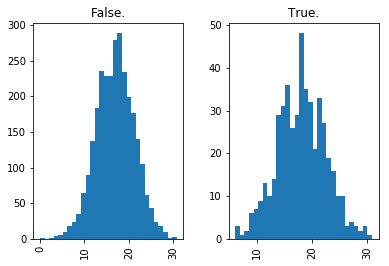

Night Mins


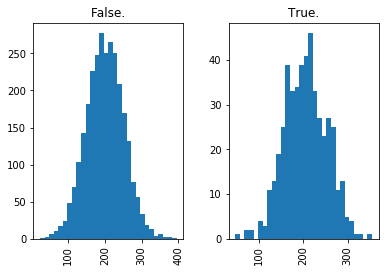

Night Calls


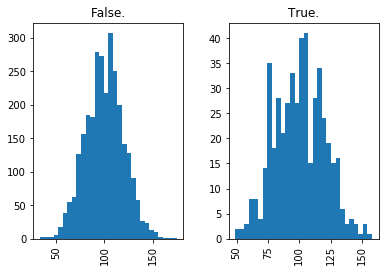

Night Charge


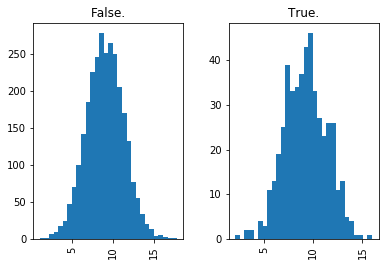

Intl Mins


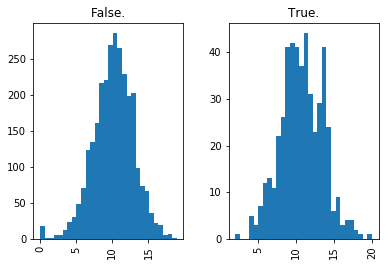

Intl Calls


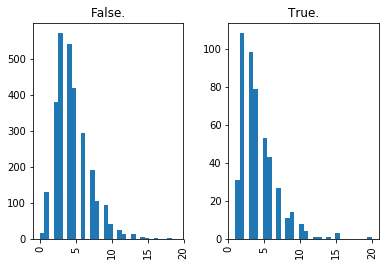

Intl Charge


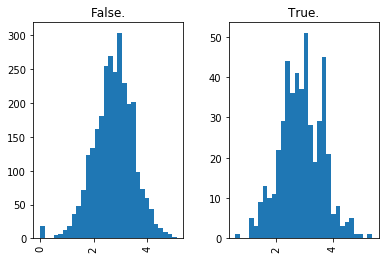

CustServ Calls


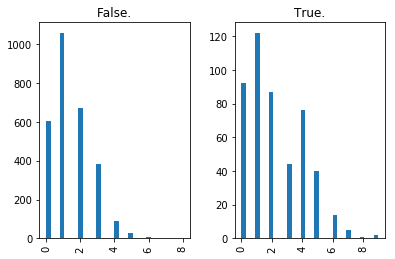

In [9]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

Interestingly we see that churners appear:
- Fairly evenly distributed geographically
- More likely to have an international plan
- Less likely to have a voicemail plan
- To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
- To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

In addition, we see that churners take on very similar distributions for features like `Day Mins` and `Day Charge`.  That's not surprising as we'd expect minutes spent talking to correlate with charges.  Let's dig deeper into the relationships between our features.

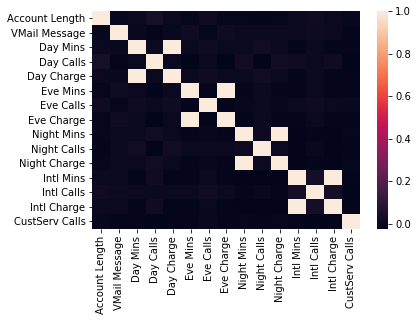

In [10]:
sns.heatmap(churn.corr())
#pd.plotting.scatter_matrix(churn, figsize=(12, 12))
#plt.show()

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [11]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)
churn.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,KS,128,415,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False.
1,OH,107,415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False.
2,NJ,137,415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False.
3,OH,84,408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False.
4,OK,75,415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False.


Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

In [12]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

In [13]:
model_data.columns.values

array(['Churn?_True.', 'Account Length', 'VMail Message', 'Day Mins',
       'Day Calls', 'Eve Mins', 'Eve Calls', 'Night Mins', 'Night Calls',
       'Intl Mins', 'Intl Calls', 'CustServ Calls', 'State_AK',
       'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
       'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA',
       'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN',
       'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD',
       'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH',
       'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH',
       'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC',
       'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
       'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY',
       'Area Code_408', 'Area Code_415', 'Area Code_510', "Int'l Plan_no",
       "Int'l Plan_yes", 'VMail Plan_no', 'VMai

In [16]:
model_data[['State_KS', 'State_OH', 'State_OK', 'State_NJ', 'Account Length']].head()

,State_KS,State_OH,State_OK,State_NJ,Account Length
0,1,0,0,0,128
1,0,1,0,0,107
2,0,0,0,1,137
3,0,1,0,0,84
4,0,0,1,0,75


In [21]:
X, y = model_data[[c for c in model_data.columns.values if c != 'Churn?_True.']], model_data['Churn?_True.']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [239]:
# train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
# train_data.to_csv('train.csv', header=False, index=False)
# validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [240]:
# boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
# boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [22]:
# Took recommended parameters from AWS example notebook
xgb_params = {"max_depth": 5,
              "eta": 0.2,
              "gamma": 4,
              "min_child_weight": 6,
              "subsample": 0.8,
              "silent": 0,
              "objective": 'binary:logistic'}

xgb_rounds = 100
xgb_model = xgb.train(xgb_params, xgb.DMatrix(X_train, label=y_train), xgb_rounds)
 
# GBT from scikit-learn
gbt_model = sklearn.ensemble.GradientBoostingClassifier()
gbt_model.fit(X_train, y_train)

[20:15:37] WARNING: /workspace/src/learner.cc:328: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

# Evaluate

Code for this section used from here: https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/

## Assess Model Utility

Let's first examine how well the model does at predicting the target variable

In [23]:
xgb_probs = xgb_model.predict(xgb.DMatrix(X_test))
xgb_preds = [round(prob) for prob in xgb_probs]

gbt_probs = gbt_model.predict_proba(X_test)[:, 1] # take positive class probabilities
gbt_preds = gbt_model.predict(X_test)

print(xgb_probs[0:10])
print('')
print(gbt_probs[0:10])

[0.23108402 0.0191191  0.06805237 0.0193365  0.9313926  0.9222411
 0.7870054  0.01043057 0.01700059 0.10605986]

[0.16078417 0.01788965 0.02646934 0.02104021 0.95712368 0.86592074
 0.81707501 0.02277509 0.04183549 0.15421402]


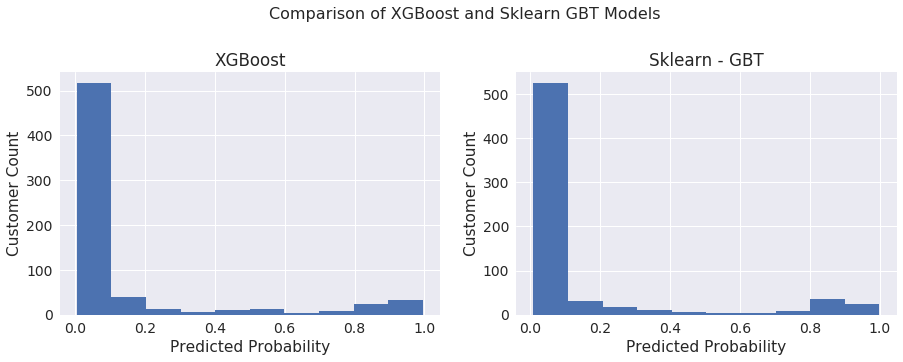

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.subplots_adjust(top=0.80)
fig.suptitle('Comparison of XGBoost and Sklearn GBT Models', size=16)
ax1.hist(xgb_probs)
ax1.set_title('XGBoost')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Customer Count')

ax2.hist(gbt_probs)
ax2.set_title('Sklearn - GBT')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Customer Count')

plt.show()

In [42]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

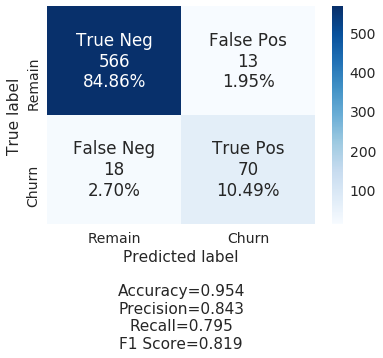

In [46]:
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1.4) # for label size

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
#fig.subplots_adjust(top=0.80)
#fig.tight_layout(pad=3.0)

#fig.suptitle('Comparison of Confusion Matrices for XGBoost and SKlearn-GBT', size=16)

xgb_cm = confusion_matrix(y_test, xgb_preds)
xgb_cm_pct = xgb_cm / xgb_cm.sum()

gbt_cm = confusion_matrix(y_test, gbt_preds)
gbt_cm_pct = gbt_cm / gbt_cm.sum()

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Remain', 'Churn']

#sns.heatmap(xgb_cm, group_names=labels, categories=categories, annot=True, annot_kws={"size": 16}, fmt="d", ax=ax1, cmap='Blues')
#ax1.set_title('XGBoost - Counts')
#ax1.set_xlabel('Predicted')
#ax1.set_ylabel('Actual')

make_confusion_matrix(xgb_cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

# sns.heatmap(gbt_cm, annot=True, annot_kws={"size": 16}, fmt="d", ax=ax2, cmap='Blues')
# ax2.set_title('Sklearn - GBT - Counts')
# ax2.set_xlabel('Predicted')
# ax2.set_ylabel('Actual')

# sns.heatmap(xgb_cm_pct, annot=True, annot_kws={"size": 16}, fmt=".1%", ax=ax3, cmap='Blues')
# ax3.set_title('XGBoost - Percentages')
# ax3.set_xlabel('Predicted')
# ax3.set_ylabel('Actual')

# sns.heatmap(gbt_cm_pct, annot=True, annot_kws={"size": 16}, fmt=".1%", ax=ax4, cmap='Blues')
# ax4.set_title('Sklearn - GBT - Percentages')
# ax4.set_xlabel('Predicted')
# ax4.set_ylabel('Actual')

plt.show()

In [47]:
xgb_tn, xgb_fp, xgb_fn, xgb_tp = xgb_cm.ravel()
gbt_tn, gbt_fp, gbt_fn, gbt_tp = gbt_cm.ravel()

#print(xgb_tn, xgb_fp, xgb_fn, xgb_tp)

xgb_fpr = xgb_fp / (xgb_tp + xgb_fp)
xgb_fnr = xgb_fn / (xgb_tn + xgb_fn)
xgb_rec = xgb_tp / (xgb_fn + xgb_tp)
xgb_prec = xgb_tp / (xgb_tp + xgb_fp)
xgb_acc = (xgb_tp + xgb_tn) / xgb_cm.sum()
xgb_f1 = (2 * xgb_prec * xgb_rec) / (xgb_prec + xgb_rec)

gbt_fpr = gbt_fp / (gbt_tp + gbt_fp)
gbt_fnr = gbt_fn / (gbt_tn + gbt_fn)
gbt_rec = gbt_tp / (gbt_fn + gbt_tp)
gbt_prec = gbt_tp / (gbt_tp + gbt_fp)
gbt_acc = (gbt_tp + gbt_tn) / gbt_cm.sum()
gbt_f1 = (2 * gbt_prec * gbt_rec) / (gbt_prec + gbt_rec)

df_idx = pd.Series(['accuracy', 'false positive', 'false negative', 'recall', 'precision', 'f1'])
pd.DataFrame({"XGB": [xgb_acc, xgb_fpr, xgb_fnr, xgb_rec, xgb_prec, xgb_f1], 
              "GBT": [gbt_acc, gbt_fpr, gbt_fnr, gbt_rec, gbt_prec, gbt_f1]}).set_index(df_idx)

,XGB,GBT
accuracy,0.953523,0.959520
false positive,0.156627,0.103896
false negative,0.030822,0.032203
recall,0.795455,0.784091
precision,0.843373,0.896104
f1,0.818713,0.836364


### Global Influence Analysis

Global influence analysis identifies the features which are most important to the model's ability to distinguish the target class. Feature Importance and Partial Dependence are two ways we can assess this aspect of what the models learned from the training data.

#### XGBoost Feature Importance

Inspiration for this analysis: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27  
Additional deeper reading: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions  

Let's start with a commonly used approach - Feature Importance. Something **less** common is an evaluation of the **multiple** types of feature importance depending on the calculation method. Here is a summary of the _five_ different importance calculations available for the open source XG Boost implementation:

`weight`: Relative number of times each feature appears in the trees of the model  
`gain`: Improvement in accuracy brought on by splitting on a feature  
`cover`: Relative quantity of observations concerned by a feature

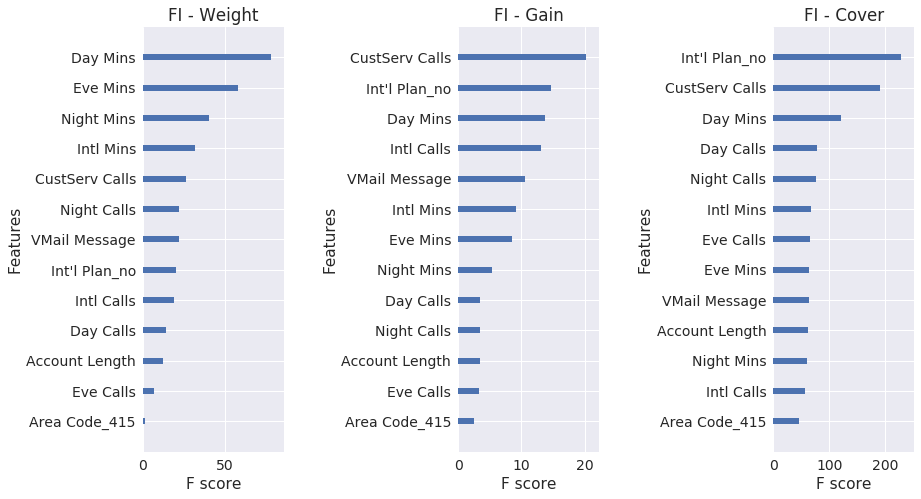

In [48]:
from xgboost import plot_importance

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
fig.subplots_adjust(top=0.80)
fig.tight_layout(pad=8.0)

plot_importance(xgb_model, importance_type='weight', title='FI - Weight', ax=ax1, show_values=False)
plot_importance(xgb_model, importance_type='gain', title='FI - Gain', ax=ax2, show_values=False)
plot_importance(xgb_model, importance_type='cover', title='FI - Cover', ax=ax3, show_values=False)

plt.show()

### What makes a measure of importance "good" or "bad"?

-- quoted almost verbatim from source above --

1) Consistency: When we force a model to rely more on a given feature, the attributed importance of that feature should not decrease. If this is not the case, we can't compare importances between models, because the assigned attribution doesn't _necessarily_ mean the model relies more on that feature for predictions.

2) Accuracy: The sum of all feature importances should equal the model importance. If this fails to hold, we don't know how the attributions assigned to each feature indicate the overall model's predictive power.

### Use SHAP Values to assess global importance

In [50]:
# Tree on XGBoost
explainerXGB = shap.TreeExplainer(xgb_model,
                                  data=shap.sample(X_test, 200),
                                  feature_perturbation='interventional', 
                                  model_output='probability') # default is log odds for XGBoost; probabilities are easier to explain

shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

# Tree on Scikit GBT
explainerSKGBT = shap.TreeExplainer(gbt_model)
shap_values_SKGBT_test = explainerSKGBT.shap_values(X_test)
shap_values_SKGBT_train = explainerSKGBT.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


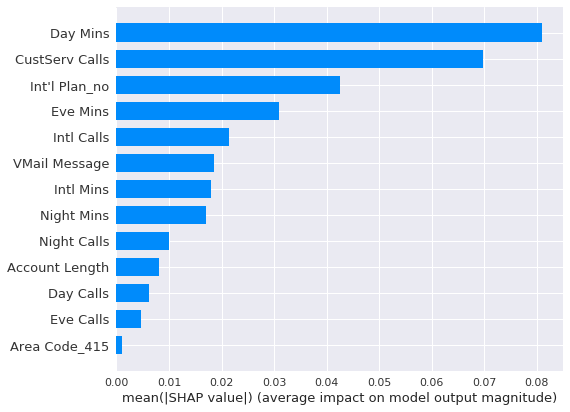

In [69]:
plot_cols = ['Day Mins', 'CustServ Calls', "Int'l Plan_no", 'Eve Mins', 
             'Intl Calls', 'VMail Message', 'Intl Mins', 'Night Mins',
              'Night Calls', 'Account Length',  'Day Calls', 'Eve Calls', 'Area Code_415']

#shap.summary_plot(shap_values_XGB_test[:, 0:len(plot_cols)], X_test[plot_cols], plot_type='bar')
shap.summary_plot(shap_values_XGB_test, X_test, plot_type='bar', max_display=len(plot_cols))

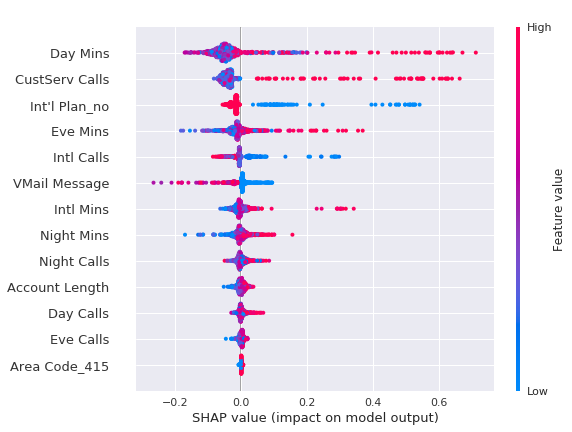

In [72]:
shap.summary_plot(shap_values_XGB_test, X_test, max_display=len(plot_cols))

In [73]:
# From: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

def ABS_SHAP(df_shap, df, keep_cols=[]):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.loc[k2['Variable'].isin(keep_cols)]
    k2 = k2.sort_values(by='SHAP_abs', ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact, Blue = Negative Impact)")

invalid value encountered in true_divide
invalid value encountered in true_divide


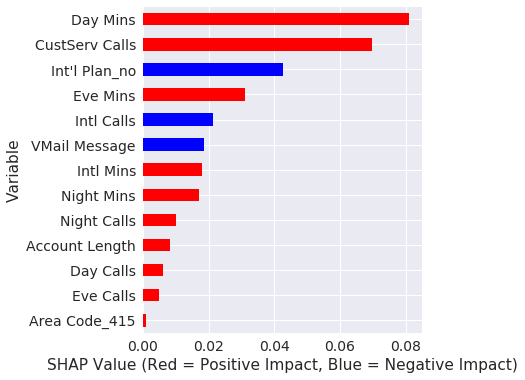

In [74]:
ABS_SHAP(shap_values_XGB_test, X_test, keep_cols=plot_cols)

### Use Shap values to understand individual features

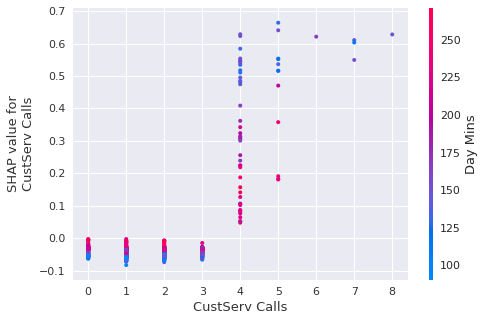

In [75]:
shap.dependence_plot("CustServ Calls", shap_values_XGB_test, X_test)

## Local Influence Analysis

### Identify interesting cases where the models give different results

From the above, we saw that XGBoost predicted 5 additional customers would churn compared to the Sklearn GBT model. We can do some local prediction analysis

In [76]:
# XGBoost
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

# Scikit GBT
df_shap_SKGBT_test = pd.DataFrame(shap_values_SKGBT_test, columns=X_test.columns.values)
df_shap_SKGBT_train = pd.DataFrame(shap_values_SKGBT_train, columns=X_train.columns.values)

In [77]:
# if a feature has 10 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()
 
print("""Showing indexes of the categorical features in training data. These are the number of customer service calls and 
one-hot encoded values indicating the customer's home state""")
print('')
print(categorical_features)

# LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
feature_names=X_train.columns.values.tolist(),
class_names=['Churn?_True.'],
categorical_features=categorical_features,
verbose=True, mode='classification')

Showing indexes of the categorical features in training data. These are the number of customer service calls and 
one-hot encoded values indicating the customer's home state

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68]


In [78]:
# initialize js for SHAP
shap.initjs()

In [93]:
# j will be the record we explain
j = 4

# Show shapely values for XGBoost model
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

In [96]:
# And for Sklearn Gradient boosted trees model
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_test[j], X_test.iloc[[j]])

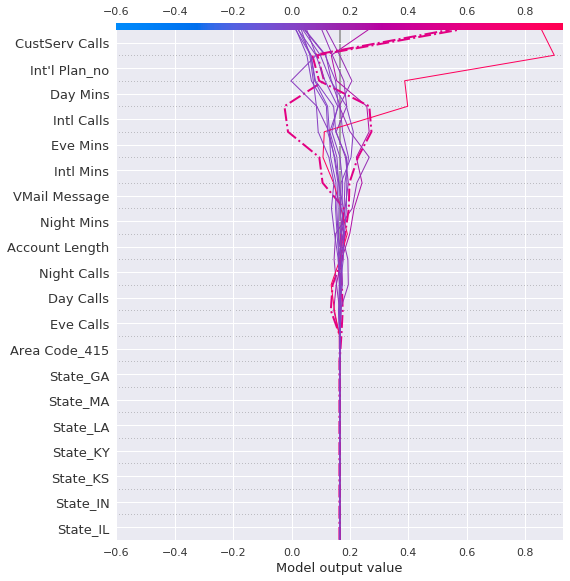

In [115]:
start = 70
end = 85

pred_50 = xgb_preds[start:end]
y_50 = y_test[start:end]
misclassified = y_50 != pred_50

shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[start:end, :], X_test.iloc[start:end], highlight=misclassified)

#misclassified